In [3]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import gaussian_filter1d, uniform_filter1d, median_filter
import warnings
warnings.filterwarnings('ignore')

#Import libraries for Deep Learning
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

print ('Libraries Loaded!')

Libraries Loaded!


In [5]:
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import pylab as plt
import numpy as np

%matplotlib inline

In [6]:
# wf.dldatabase('mitdb', '/home/nick/Desktop/Electrocardiogram/Data')

In [7]:
paths = glob('Data/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()

In [9]:
beat_annotations = ['N', 'L', 'R', 'B',
                    'A', 'a', 'J', 'S', 'V',
                    'r', 'F', 'e', 'j', 'n',
                    'E', '/', 'f', 'Q', '?'] 
# 0.5 of how much signal we want per beat
half_qrs = 180

In [10]:
# Prepare the final container
base = pd.DataFrame()

for path in tqdm(paths):
    # print 'Working with file:', path
    ann = wf.rdann(path, 'atr')
    record = wf.rdsamp(path)
    # We want just the signals
    data = record.p_signals
    
    # Prepare containers
    signals, classes = [], []
    
    # Beat extraction
    for it, beat in enumerate(ann.symbol):#enumerate(ann.anntype)
        if beat in beat_annotations:
            # Defend from the dumb annotation hacking my folder structure
            if beat == '/': beat = 'C'
                
            sta = ann.sample[it-1] - half_qrs
            end = ann.sample[it-1] + half_qrs
            qrs = data[sta : end, :]
            # This may happen at the edges
            if len(qrs) != 2 * half_qrs: continue
            
            # Keep the channel type in the class name
            for ch in range(2):
                #beat_class = '{}_{}'.format(record.signame[ch], beat)
                signals.append(qrs[:, ch])
                classes.append(beat)
                
    new_frame = pd.DataFrame({'qrs_data' : signals,
                              'qrs_type' : classes})
    # Cumulate
    base = base.append(new_frame)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:06<00:00,  7.52it/s]


In [193]:
classes = base['qrs_type'].value_counts()
ids = classes.iloc[:] > 100
classes = classes.loc[ids]

# Show just the top ten
print (classes, classes.shape)

N    150006
L     16140
R     14504
V     14252
C     14042
A      5092
f      1964
F      1604
j       458
a       300
E       212
J       166
Name: qrs_type, dtype: int64 (12,)


In [194]:
base.qrs_type.unique()

array(['N', 'A', 'V', 'Q', 'C', 'f', 'F', 'j', 'L', 'a', 'J', 'R', 'E',
       'S', 'e'], dtype=object)

In [195]:
# Extract just one exemplary qrs
def get_class(ind):
    classes_index = classes.index
    qrs_type = classes_index[ind]
    ids = base['qrs_type'] == qrs_type
    partial = base.loc[ids]
    return partial, qrs_type

In [196]:
def rec_plot(s, eps=None, steps=None):
    if eps==None: eps=.01
    if steps==None: steps=10
    N = s.size
    S = np.repeat(s[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
    return Z

In [197]:
# for i in range(100):
#     partial, qrs_type = get_class(i)
#     qrs = partial.iloc[i]['qrs_data']
#     #plt.plot(qrs)
#     plt.show()
#     plt.imshow(rec_plot(qrs))
#     plt.title('QRS of type: {}'.format(qrs_type))

In [198]:
base_new= base[base['qrs_type'].isin(list(classes.index))]
base_new.qrs_type.unique().shape

(12,)

In [199]:
X= np.vstack(list(base_new['qrs_data']))
Y= np.array(base_new['qrs_type'])

In [200]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
Y= le.fit_transform(Y)
from keras.utils.np_utils import to_categorical
Y = to_categorical(Y)

In [201]:
X = X[:,:,np.newaxis]

In [202]:
# simple cross-validation.(k-fold cross validation not used because of lot of time being taken for training k*timenow)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, stratify= Y)

In [203]:
X.shape

(218740, 360, 1)

In [204]:

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [205]:

# x_train = x_train[:,:,np.newaxis]
# x_test = x_test[:,:,np.newaxis]

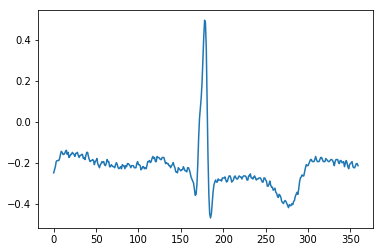

In [206]:
plt.plot(X[1])

In [207]:
x_train.shape

(196866, 360, 1)

In [208]:
Y[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [209]:
y_train.shape

(196866, 12)

In [210]:
model = Sequential()
model.add(Conv1D(filters=12, kernel_size=3, input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPool1D(strides=1))

model.add(Conv1D(filters=24, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(MaxPool1D(strides=1))

model.add(Flatten())

model.add(Dense(32, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(32, activation='elu'))

model.add(Dense(12,  activation='softmax'))

In [218]:
print (model4.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 360, 1)       0                                            
__________________________________________________________________________________________________
conv1d_118 (Conv1D)             (None, 360, 10)      50          input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 360, 10)      40          conv1d_118[0][0]                 
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 360, 10)      0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
merge_32 (

In [212]:
from keras.layers import merge, LSTM

In [219]:
x_input= Input(shape= x_train.shape[1:])
x= Conv1D(filters=10, kernel_size=4, padding='same')(x_input)
x=BatchNormalization()(x)
x=Activation('elu')(x)


m=merge([x, x_input], mode= 'concat')

# x= Conv1D(filters=16, kernel_size=11, activation='relu')(m)
# x=MaxPool1D(strides=4)(x)
# x=BatchNormalization()(x)

x= Conv1D(filters=24, kernel_size=4)(m)
#x=MaxPool1D(strides=4)(x)
x=BatchNormalization()(x)
x=Activation('elu')(x)

x= Conv1D(filters=32, kernel_size=6)(x)
#x= MaxPool1D(strides=4)(x)
x=Activation('elu')(x)

x=Flatten()(x)
#x=LSTM(4)(x)

x=Dropout(.3)(x)
x=Dense(48, activation='elu')(x)
x=Dropout(0.3)(x)
x=Dense(48, activation='elu')(x)
x=Dense(12, activation='softmax')(x)
model4= Model(input=x_input, output= x)

#model4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [220]:
model4.compile(optimizer=Adam(4e-5), loss = 'categorical_crossentropy', metrics=['accuracy'])
hist = model4.fit(x_train, y_train, 1024, 
                           validation_data=(x_test, y_test), 
                           verbose=1, epochs=10)

Train on 196866 samples, validate on 21874 samples
Epoch 1/10
196866/196866 [==============================] - ETA: 23:16 - loss: 2.7732 - acc: 0.09 - ETA: 14:45 - loss: 2.6475 - acc: 0.12 - ETA: 11:54 - loss: 2.5280 - acc: 0.16 - ETA: 10:27 - loss: 2.4438 - acc: 0.20 - ETA: 9:36 - loss: 2.3556 - acc: 0.2416 - ETA: 9:06 - loss: 2.2765 - acc: 0.282 - ETA: 8:45 - loss: 2.2202 - acc: 0.311 - ETA: 8:26 - loss: 2.1510 - acc: 0.343 - ETA: 8:18 - loss: 2.0849 - acc: 0.373 - ETA: 8:09 - loss: 2.0245 - acc: 0.400 - ETA: 8:00 - loss: 1.9740 - acc: 0.423 - ETA: 7:55 - loss: 1.9345 - acc: 0.442 - ETA: 7:53 - loss: 1.8927 - acc: 0.460 - ETA: 7:56 - loss: 1.8513 - acc: 0.477 - ETA: 8:01 - loss: 1.8121 - acc: 0.492 - ETA: 8:04 - loss: 1.7794 - acc: 0.505 - ETA: 8:02 - loss: 1.7518 - acc: 0.516 - ETA: 7:58 - loss: 1.7271 - acc: 0.526 - ETA: 7:54 - loss: 1.7008 - acc: 0.535 - ETA: 7:57 - loss: 1.6786 - acc: 0.543 - ETA: 7:56 - loss: 1.6573 - acc: 0.551 - ETA: 7:53 - loss: 1.6375 - acc: 0.557 - ETA: 7:5

196866/196866 [==============================] - ETA: 8:20 - loss: 0.7182 - acc: 0.821 - ETA: 8:17 - loss: 0.7354 - acc: 0.814 - ETA: 8:16 - loss: 0.7410 - acc: 0.809 - ETA: 8:14 - loss: 0.7403 - acc: 0.807 - ETA: 8:12 - loss: 0.7375 - acc: 0.809 - ETA: 8:07 - loss: 0.7352 - acc: 0.808 - ETA: 8:02 - loss: 0.7414 - acc: 0.807 - ETA: 7:59 - loss: 0.7476 - acc: 0.805 - ETA: 7:57 - loss: 0.7505 - acc: 0.803 - ETA: 7:54 - loss: 0.7480 - acc: 0.805 - ETA: 7:53 - loss: 0.7415 - acc: 0.806 - ETA: 7:52 - loss: 0.7395 - acc: 0.807 - ETA: 7:50 - loss: 0.7406 - acc: 0.808 - ETA: 7:49 - loss: 0.7432 - acc: 0.807 - ETA: 7:48 - loss: 0.7418 - acc: 0.807 - ETA: 7:45 - loss: 0.7372 - acc: 0.808 - ETA: 7:42 - loss: 0.7351 - acc: 0.809 - ETA: 7:39 - loss: 0.7335 - acc: 0.809 - ETA: 7:36 - loss: 0.7317 - acc: 0.810 - ETA: 7:33 - loss: 0.7301 - acc: 0.810 - ETA: 7:32 - loss: 0.7267 - acc: 0.811 - ETA: 7:29 - loss: 0.7266 - acc: 0.811 - ETA: 7:27 - loss: 0.7246 - acc: 0.812 - ETA: 7:24 - loss: 0.7236 - acc:

196866/196866 [==============================] - ETA: 7:22 - loss: 0.5831 - acc: 0.851 - ETA: 7:23 - loss: 0.6055 - acc: 0.843 - ETA: 7:17 - loss: 0.6205 - acc: 0.837 - ETA: 7:13 - loss: 0.6417 - acc: 0.832 - ETA: 7:11 - loss: 0.6243 - acc: 0.838 - ETA: 7:06 - loss: 0.6285 - acc: 0.838 - ETA: 7:03 - loss: 0.6253 - acc: 0.840 - ETA: 6:59 - loss: 0.6284 - acc: 0.838 - ETA: 6:56 - loss: 0.6267 - acc: 0.838 - ETA: 6:53 - loss: 0.6248 - acc: 0.839 - ETA: 6:50 - loss: 0.6225 - acc: 0.839 - ETA: 6:47 - loss: 0.6265 - acc: 0.839 - ETA: 6:45 - loss: 0.6277 - acc: 0.840 - ETA: 6:42 - loss: 0.6293 - acc: 0.839 - ETA: 6:39 - loss: 0.6248 - acc: 0.840 - ETA: 6:36 - loss: 0.6245 - acc: 0.840 - ETA: 6:34 - loss: 0.6227 - acc: 0.841 - ETA: 6:31 - loss: 0.6193 - acc: 0.841 - ETA: 6:29 - loss: 0.6207 - acc: 0.841 - ETA: 6:27 - loss: 0.6177 - acc: 0.841 - ETA: 6:24 - loss: 0.6175 - acc: 0.841 - ETA: 6:22 - loss: 0.6169 - acc: 0.841 - ETA: 6:20 - loss: 0.6136 - acc: 0.843 - ETA: 6:17 - loss: 0.6140 - acc:

196866/196866 [==============================] - ETA: 8:11 - loss: 0.5684 - acc: 0.858 - ETA: 8:14 - loss: 0.5229 - acc: 0.870 - ETA: 8:08 - loss: 0.5095 - acc: 0.875 - ETA: 8:06 - loss: 0.5165 - acc: 0.874 - ETA: 8:03 - loss: 0.5235 - acc: 0.872 - ETA: 8:03 - loss: 0.5307 - acc: 0.869 - ETA: 8:00 - loss: 0.5265 - acc: 0.870 - ETA: 7:56 - loss: 0.5294 - acc: 0.869 - ETA: 7:54 - loss: 0.5343 - acc: 0.867 - ETA: 7:52 - loss: 0.5292 - acc: 0.868 - ETA: 7:54 - loss: 0.5329 - acc: 0.866 - ETA: 7:53 - loss: 0.5325 - acc: 0.867 - ETA: 7:51 - loss: 0.5317 - acc: 0.867 - ETA: 7:48 - loss: 0.5287 - acc: 0.868 - ETA: 7:46 - loss: 0.5311 - acc: 0.867 - ETA: 7:43 - loss: 0.5351 - acc: 0.866 - ETA: 7:40 - loss: 0.5319 - acc: 0.867 - ETA: 7:37 - loss: 0.5305 - acc: 0.867 - ETA: 7:34 - loss: 0.5289 - acc: 0.868 - ETA: 7:31 - loss: 0.5255 - acc: 0.868 - ETA: 7:28 - loss: 0.5239 - acc: 0.869 - ETA: 7:24 - loss: 0.5242 - acc: 0.869 - ETA: 7:22 - loss: 0.5256 - acc: 0.868 - ETA: 7:19 - loss: 0.5248 - acc:

196866/196866 [==============================] - ETA: 7:22 - loss: 0.4699 - acc: 0.875 - ETA: 7:16 - loss: 0.4698 - acc: 0.875 - ETA: 7:15 - loss: 0.4689 - acc: 0.876 - ETA: 7:10 - loss: 0.4804 - acc: 0.874 - ETA: 7:06 - loss: 0.4897 - acc: 0.872 - ETA: 7:03 - loss: 0.4957 - acc: 0.871 - ETA: 7:01 - loss: 0.4963 - acc: 0.869 - ETA: 6:58 - loss: 0.4936 - acc: 0.869 - ETA: 6:54 - loss: 0.4969 - acc: 0.868 - ETA: 6:52 - loss: 0.5002 - acc: 0.868 - ETA: 6:48 - loss: 0.4985 - acc: 0.869 - ETA: 6:46 - loss: 0.4967 - acc: 0.870 - ETA: 6:43 - loss: 0.4923 - acc: 0.872 - ETA: 6:40 - loss: 0.4936 - acc: 0.872 - ETA: 6:37 - loss: 0.4923 - acc: 0.872 - ETA: 6:35 - loss: 0.4936 - acc: 0.872 - ETA: 6:32 - loss: 0.4933 - acc: 0.872 - ETA: 6:30 - loss: 0.4912 - acc: 0.872 - ETA: 6:27 - loss: 0.4907 - acc: 0.872 - ETA: 6:25 - loss: 0.4894 - acc: 0.873 - ETA: 6:23 - loss: 0.4895 - acc: 0.873 - ETA: 6:21 - loss: 0.4904 - acc: 0.873 - ETA: 6:19 - loss: 0.4906 - acc: 0.873 - ETA: 6:17 - loss: 0.4909 - acc:

196866/196866 [==============================] - ETA: 8:08 - loss: 0.4134 - acc: 0.895 - ETA: 7:31 - loss: 0.4355 - acc: 0.891 - ETA: 7:21 - loss: 0.4424 - acc: 0.891 - ETA: 7:41 - loss: 0.4542 - acc: 0.888 - ETA: 7:54 - loss: 0.4492 - acc: 0.889 - ETA: 7:52 - loss: 0.4436 - acc: 0.889 - ETA: 7:48 - loss: 0.4458 - acc: 0.888 - ETA: 7:47 - loss: 0.4474 - acc: 0.887 - ETA: 7:39 - loss: 0.4529 - acc: 0.885 - ETA: 7:35 - loss: 0.4552 - acc: 0.884 - ETA: 7:29 - loss: 0.4555 - acc: 0.884 - ETA: 7:25 - loss: 0.4554 - acc: 0.884 - ETA: 7:22 - loss: 0.4562 - acc: 0.883 - ETA: 7:20 - loss: 0.4574 - acc: 0.883 - ETA: 7:18 - loss: 0.4557 - acc: 0.884 - ETA: 7:15 - loss: 0.4517 - acc: 0.885 - ETA: 7:10 - loss: 0.4541 - acc: 0.884 - ETA: 7:05 - loss: 0.4534 - acc: 0.884 - ETA: 7:00 - loss: 0.4550 - acc: 0.884 - ETA: 6:56 - loss: 0.4523 - acc: 0.885 - ETA: 6:52 - loss: 0.4525 - acc: 0.884 - ETA: 6:48 - loss: 0.4532 - acc: 0.884 - ETA: 6:45 - loss: 0.4537 - acc: 0.884 - ETA: 6:41 - loss: 0.4524 - acc:

196866/196866 [==============================] - ETA: 7:46 - loss: 0.4181 - acc: 0.893 - ETA: 7:25 - loss: 0.4299 - acc: 0.890 - ETA: 7:13 - loss: 0.4305 - acc: 0.890 - ETA: 7:10 - loss: 0.4419 - acc: 0.887 - ETA: 7:21 - loss: 0.4379 - acc: 0.887 - ETA: 7:21 - loss: 0.4395 - acc: 0.886 - ETA: 7:19 - loss: 0.4398 - acc: 0.887 - ETA: 7:23 - loss: 0.4297 - acc: 0.889 - ETA: 7:20 - loss: 0.4261 - acc: 0.890 - ETA: 7:15 - loss: 0.4253 - acc: 0.890 - ETA: 7:10 - loss: 0.4285 - acc: 0.889 - ETA: 7:13 - loss: 0.4280 - acc: 0.889 - ETA: 7:13 - loss: 0.4348 - acc: 0.888 - ETA: 7:13 - loss: 0.4324 - acc: 0.889 - ETA: 7:10 - loss: 0.4306 - acc: 0.889 - ETA: 7:06 - loss: 0.4290 - acc: 0.890 - ETA: 7:04 - loss: 0.4301 - acc: 0.889 - ETA: 7:03 - loss: 0.4308 - acc: 0.888 - ETA: 7:01 - loss: 0.4312 - acc: 0.888 - ETA: 6:57 - loss: 0.4333 - acc: 0.888 - ETA: 6:53 - loss: 0.4343 - acc: 0.888 - ETA: 6:50 - loss: 0.4331 - acc: 0.888 - ETA: 6:48 - loss: 0.4315 - acc: 0.889 - ETA: 6:46 - loss: 0.4319 - acc:

196866/196866 [==============================] - ETA: 8:30 - loss: 0.4966 - acc: 0.872 - ETA: 8:11 - loss: 0.4552 - acc: 0.880 - ETA: 7:58 - loss: 0.4558 - acc: 0.879 - ETA: 7:46 - loss: 0.4469 - acc: 0.882 - ETA: 7:36 - loss: 0.4289 - acc: 0.887 - ETA: 7:31 - loss: 0.4222 - acc: 0.891 - ETA: 7:27 - loss: 0.4176 - acc: 0.893 - ETA: 7:23 - loss: 0.4149 - acc: 0.893 - ETA: 7:21 - loss: 0.4216 - acc: 0.891 - ETA: 7:15 - loss: 0.4215 - acc: 0.890 - ETA: 7:10 - loss: 0.4232 - acc: 0.889 - ETA: 7:05 - loss: 0.4184 - acc: 0.890 - ETA: 7:01 - loss: 0.4220 - acc: 0.889 - ETA: 6:59 - loss: 0.4211 - acc: 0.890 - ETA: 6:55 - loss: 0.4246 - acc: 0.889 - ETA: 6:51 - loss: 0.4271 - acc: 0.888 - ETA: 6:49 - loss: 0.4265 - acc: 0.888 - ETA: 6:46 - loss: 0.4230 - acc: 0.889 - ETA: 6:45 - loss: 0.4247 - acc: 0.889 - ETA: 6:43 - loss: 0.4222 - acc: 0.890 - ETA: 6:40 - loss: 0.4203 - acc: 0.890 - ETA: 6:38 - loss: 0.4216 - acc: 0.890 - ETA: 6:34 - loss: 0.4207 - acc: 0.890 - ETA: 6:31 - loss: 0.4199 - acc:

196866/196866 [==============================] - ETA: 7:28 - loss: 0.3789 - acc: 0.900 - ETA: 7:59 - loss: 0.4098 - acc: 0.895 - ETA: 8:16 - loss: 0.4040 - acc: 0.897 - ETA: 8:00 - loss: 0.4039 - acc: 0.898 - ETA: 7:52 - loss: 0.3956 - acc: 0.900 - ETA: 7:42 - loss: 0.3923 - acc: 0.899 - ETA: 7:34 - loss: 0.3918 - acc: 0.899 - ETA: 7:36 - loss: 0.3943 - acc: 0.899 - ETA: 7:37 - loss: 0.3962 - acc: 0.899 - ETA: 7:37 - loss: 0.3955 - acc: 0.898 - ETA: 7:37 - loss: 0.3989 - acc: 0.897 - ETA: 7:37 - loss: 0.4029 - acc: 0.896 - ETA: 7:35 - loss: 0.4020 - acc: 0.896 - ETA: 7:29 - loss: 0.4039 - acc: 0.896 - ETA: 7:24 - loss: 0.4046 - acc: 0.896 - ETA: 7:20 - loss: 0.4050 - acc: 0.896 - ETA: 7:15 - loss: 0.4060 - acc: 0.895 - ETA: 7:14 - loss: 0.4054 - acc: 0.895 - ETA: 7:14 - loss: 0.4045 - acc: 0.895 - ETA: 7:14 - loss: 0.4036 - acc: 0.896 - ETA: 7:11 - loss: 0.4050 - acc: 0.896 - ETA: 7:07 - loss: 0.4040 - acc: 0.896 - ETA: 7:03 - loss: 0.4035 - acc: 0.897 - ETA: 6:59 - loss: 0.4040 - acc:

196866/196866 [==============================] - ETA: 7:15 - loss: 0.4292 - acc: 0.897 - ETA: 7:31 - loss: 0.4122 - acc: 0.900 - ETA: 7:43 - loss: 0.3986 - acc: 0.902 - ETA: 7:50 - loss: 0.4027 - acc: 0.899 - ETA: 7:49 - loss: 0.4048 - acc: 0.894 - ETA: 7:45 - loss: 0.3927 - acc: 0.897 - ETA: 7:40 - loss: 0.3915 - acc: 0.896 - ETA: 7:33 - loss: 0.3928 - acc: 0.896 - ETA: 7:27 - loss: 0.3935 - acc: 0.896 - ETA: 7:24 - loss: 0.3883 - acc: 0.897 - ETA: 7:18 - loss: 0.3880 - acc: 0.897 - ETA: 7:13 - loss: 0.3855 - acc: 0.899 - ETA: 7:10 - loss: 0.3887 - acc: 0.897 - ETA: 7:06 - loss: 0.3880 - acc: 0.898 - ETA: 7:02 - loss: 0.3882 - acc: 0.897 - ETA: 6:58 - loss: 0.3878 - acc: 0.897 - ETA: 6:54 - loss: 0.3876 - acc: 0.898 - ETA: 6:51 - loss: 0.3887 - acc: 0.897 - ETA: 6:47 - loss: 0.3883 - acc: 0.898 - ETA: 6:45 - loss: 0.3883 - acc: 0.897 - ETA: 6:41 - loss: 0.3886 - acc: 0.897 - ETA: 6:38 - loss: 0.3889 - acc: 0.897 - ETA: 6:35 - loss: 0.3922 - acc: 0.896 - ETA: 6:32 - loss: 0.3948 - acc:

In [185]:
model3 = Sequential()
model3.add(Conv1D(filters=16, kernel_size=11, activation='selu', input_shape=x_train.shape[1:]))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=64, kernel_size=11, activation='selu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='selu'))
model3.add(MaxPool1D(strides=4))
model3.add(BatchNormalization())
model3.add(Conv1D(filters=32, kernel_size=11, activation='selu'))
model3.add(MaxPool1D(strides=4))
model3.add(LSTM(10))
model3.add(Dense(6, activation='sigmoid'))

ValueError: Negative dimension size caused by subtracting 11 from 3 for 'conv1d_103/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,3,32], [1,11,32,32].

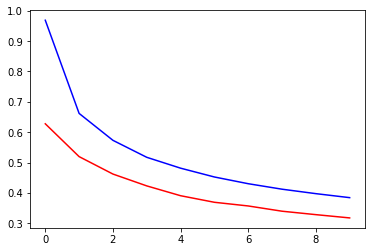

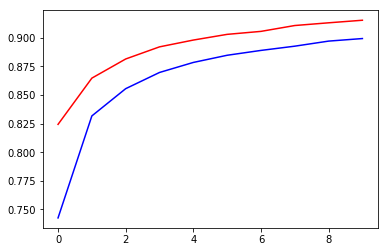

In [221]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()